<div style="float:left">
    <h1 style="width:450px">Practical 10: Grouping Data</h1>
    <h2 style="width:450px">Classification &amp; Clusters</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: _this_ group of observations are similar to one another, _that_ group is dissimilar to this group. But what defines similarity and difference? There is no _one_ answer to that question and so there are many different ways to cluster data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts.

#### Preamble

In [32]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [33]:
pwd

'/Users/sophieayling/Documents/GitHub/i2p/practicals'

#### Initialise the Scalers and Transformers

In [34]:
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

#### Set Up Functions for Plotting

In [35]:
def plt_ldn(w, b):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

## Load Data

#### Load Water and Boroughs

In [36]:
# Load Water GeoPackage
w_path = os.path.join('..','data','geo','Water.gpkg')
if not os.path.exists(w_path):
    water = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Water.gpkg?raw=true')
    water.to_file(w_path)
    print("Downloaded Water.gpkg file.")
else:
    water = gpd.read_file(w_path)

# Boroughs GeoPackage
b_path = os.path.join('..', 'data','geo','Boroughs.gpkg')
if not os.path.exists(b_path):
    boroughs = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
    boroughs.to_file(b_path)
    print("Downloaded Boroughs.gpkg file.")
else:
    boroughs = gpd.read_file(b_path)

#### Load the MSOA GeoData

You should have this locally...

In [37]:
msoas = gpd.read_file(os.path.join('..','data','geo','London_MSOAs.gpkg'), driver='GPKG')
msoas = msoas.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm'])

#### Load the Listings Data

Feel free to load your local copy rather than loading via the URL:

In [38]:
url = 'https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings.csv.gz?raw=true'
df = pd.read_csv(url, compression='gzip', low_memory=False, 
                 usecols=['room_type','longitude','latitude','price'])
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 74,120 x 4


You should have: `Data frame is 74,120 x 4`.

In [39]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
                                     
print(gdf.geometry.crs)

epsg:4326


In [40]:
# to decide what it needs converting to I looked up the msoa conversion for london 
gdf = gdf.to_crs('epsg:27700')

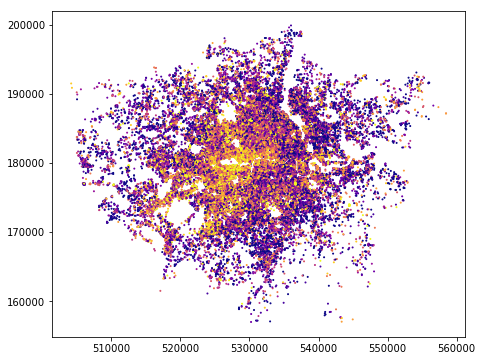

In [41]:
gdf.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1, figsize=(8,6));

#### Aggregate Listings by MSOA

Next, use a spatial join to link the listings to MSOAs.

In [42]:
# ml == MSOA Listings
ml = gpd.sjoin(msoas,gdf, how='left').drop(
                    columns=['latitude','longitude','index_right']
)
ml.head()

,MSOA11CD,geometry,room_type,price
0,E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",Entire home/apt,135.00
0,E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",Entire home/apt,90.00
0,E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",Entire home/apt,999.00
0,E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",Entire home/apt,118.00
0,E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",Private room,40.00


Now we want a count of room types by MSOA:

In [43]:
mlgc = ml.groupby(['MSOA11CD', 'room_type'])['price'].agg(Count='count').reset_index() # msoa listings grouped counts
mlgc.head()

,MSOA11CD,room_type,Count
0,E02000001,Entire home/apt,398
1,E02000001,Hotel room,4
2,E02000001,Private room,48
3,E02000001,Shared room,2
4,E02000002,Private room,10


You should get: 

|    | MSOA11CD | room_type | Count |
| -: | :------- | :-------- | ----: |
| 0 | E02000001 | Entire home/apt | 398 |
| 1 | E02000001 | Hotel room | 4 |
| 2 | E02000001 | Private room | 48 |
| 3 | E02000001 | Shared room | 2 |
| 4 | E02000002 | Private room | 10 |

And let's also get the median price by MSOA...

In [44]:
mlgp = ml.groupby('MSOA11CD')['price'].agg(price='median').reset_index() # msoa listings grouped price
mlgp.head()

,MSOA11CD,price
0,E02000001,125.00
1,E02000002,50.00
2,E02000003,40.00
3,E02000004,29.00
4,E02000005,69.00


For comparison purposes: 

|    | MSOA11CD | price |
| -: | :------- | ----: |
| 0 | E02000001 | 125.00 |
| 1 | E02000002 | 50.00 |
| 2 | E02000003 | 40.00 | 
| 3 | E02000004 | 29.00 |
| 4 | E02000005 | 69.00 |

The highest median price is $1,880, which implies not just heavy skew but something a bit out-of-this-world.

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Warning</i>: I have a strong suspicion that price is <i>so</i> skewed that using it in most clustering contexts is almost impossible. This is why I use the PowerTransformer below.</div>

Now we can make use of the pivot table function to generate counts by MSOA in 'wide' format. I'd suggest using the empty cell below to work out the pivot table function first before assigning it back to the `mlgc` variable and overwriting the existing data.

In [45]:
mlgc.pivot(index=['MSOA11CD'], columns=['room_type'], values=['Count']).reset_index()

MSOA11CD           Count                                    
room_type            Entire home/apt Hotel room Private room Shared room
0          E02000001          398.00       4.00        48.00        2.00
1          E02000002             nan        nan        10.00         nan
2          E02000003            5.00        nan        19.00         nan
3          E02000004             nan        nan         1.00         nan
4          E02000005            3.00        nan         9.00         nan
..               ...             ...        ...          ...         ...
975        E02006927           22.00        nan        20.00        2.00
976        E02006928           51.00       3.00        42.00         nan
977        E02006929          109.00       4.00        65.00         nan
978        E02006930           61.00       4.00        51.00        1.00
979        E02006931           74.00        nan        49.00        1.00

[980 rows x 5 columns]

|    | MSOA11CD |       |       |       | Count |
| -: | :------- | ----: | ----: | ----: | ----: |
| **room_type** | | **Entire home/apt** | **Hotel room** | **Private room** | **Shared room** |
| 0 | E02000001 | 398.00 | 4.00 | 48.00 | 2.00 | 
| 1 | E02000002 | nan | nan | 10.00 | nan |
| 2 | E02000003 | 5.00 | nan | 19.00 | nan |

In [46]:
mlgc = mlgc.pivot(index=['MSOA11CD'], columns=['room_type'], values=['Count']).reset_index()
mlgc.columns = ['MSOA11CD','Entire home/apt','Hotel room','Private room','Shared room']
mlgc.drop(columns=['Hotel room','Shared room'], inplace=True)
mlgc.head()

,MSOA11CD,Entire home/apt,Private room
0,E02000001,398.00,48.00
1,E02000002,nan,10.00
2,E02000003,5.00,19.00
3,E02000004,nan,1.00
4,E02000005,3.00,9.00


Merge the grouped counts and price back to a `mlg` (MSOA Listings Grouped) data frame:

In [47]:
mlg = pd.merge(mlgc, mlgp, on ="MSOA11CD") # the two data sets I want merged and just on  what value
mlg.info() # this shows us where there are missing values
#the following code then sets the MSOA11CD to the index column and then rills the missing values of all the others up to 980
mlg = mlg.fillna(0).set_index('MSOA11CD')
mlg.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980 entries, 0 to 979
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSOA11CD         980 non-null    object 
 1   Entire home/apt  944 non-null    float64
 2   Private room     977 non-null    float64
 3   price            980 non-null    float64
dtypes: float64(3), object(1)
memory usage: 38.3+ KB


,Entire home/apt,Private room,price
MSOA11CD,,,
E02000001,398.00,48.00,125.00
E02000002,0.00,10.00,50.00
E02000003,5.00,19.00,40.00
E02000004,0.00,1.00,29.00
E02000005,3.00,9.00,69.00


Apply a PowerTransform to every column using a loop and `fit_transform`:

In [ ]:
for c in mlg.columns.values:
    mlg[c] = pts.fit_transform(mlg[c].values.reshape(-1,1))
    
    # pts is defined up on the third line as denoting a power_transformer. 
    # It is necessary to reshape the values before doing this, hence the reshape
    # this transformation enables a comparison across these characteristics in the dataset, 
    # preserving some aspect of the relationship between them
mlg.head(3)

For comparison:

|      | Entire home/apt | Private room | price |
| :--- | --------------: | -----------: | ----: |
| **MSOA11CD** |  |  |  |
| E02000001 | 2.12 | 0.81 | 1.81 | 
| E02000002 | -1.99 | -0.76 | -0.21 | 
| E02000003| -0.66 | -0.16 | -0.83 |

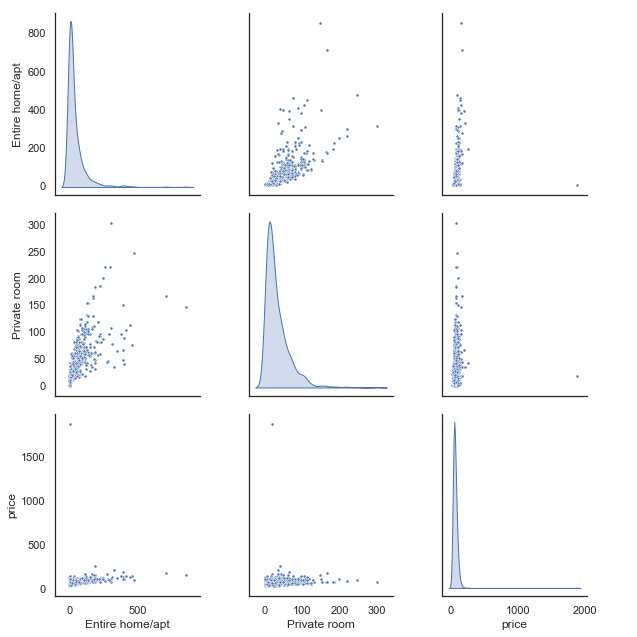

In [48]:
sns.set(style="white")
sns.pairplot(mlg, markers=".", height=3, diag_kind='kde');

#### Load the Reduced Dimension Data from Week 9

In [49]:
rddf = gpd.read_file(os.path.join('../','data','clean','Reduced_Dimension_Data.gpkg'), driver='GPKG').set_index('MSOA11CD')
rddf.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm','Subregion',
                   'geometry','Dimension 1','Dimension 2'], inplace=True)
print(f"Reduced Dimensionality Data Frame is {rddf.shape[0]:,} x {rddf.shape[1]:,}")
rddf.head()

Reduced Dimensionality Data Frame is 983 x 10


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10
MSOA11CD,,,,,,,,,,
E02000001,2.72,0.90,-0.10,-1.85,0.16,5.70,4.44,-1.47,-0.68,-0.59
E02000002,-1.13,-0.44,-0.65,-0.69,1.05,0.54,0.91,0.06,0.16,0.98
E02000003,-0.34,-0.16,1.61,0.26,0.28,-0.22,1.01,0.90,0.41,-0.28
E02000004,-0.86,-1.21,-0.64,-0.87,0.21,0.64,0.59,0.84,-0.34,0.30
E02000005,-0.92,-0.36,0.58,-0.35,0.79,-0.21,1.24,1.39,0.59,0.14


You should get `Reduced Dimensionality Data Frame is 983 x 10`.

Merge the `rddf` and `mlg` files using the MSOA11CD and rescale all columns using MinMaxScaler:

In [51]:
# Merge the reducded dimensionality data frame with the msoa listings grouped data frame
cldf = pd.merge(rddf, mlg, on = "MSOA11CD" )

# Rescale the columns using the MinMaxScaler set up in the Preamble
for c in cldf.columns:
    cldf[c] = mms.fit_transform(cldf[c].values.reshape(-1,1))

# We also create a 'result set' (rs) data frame to hold the 
# results of the clustering operation
rs   = pd.merge(msoas, cldf, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')

# Check output
cldf.head(2)[['Component 1','Component 2','price']]

,Component 1,Component 2,price
MSOA11CD,,,
E02000001,-0.08,0.12,-0.89
E02000002,-0.88,-0.33,-0.97


A partial sample: 

| MSOA11CD | Component 1 | Component 2 | price |
| :------- | ----------: | ----------: | ----: |
| E02000001 | -0.08 | 0.12 | 0.25 |
| E02000002 | -0.88 | -0.33 | -0.42 |

#### Select columns to plot

Plotting all columns is computationally costly and for little utility... it's better to just select a few at random.

In [52]:
cols_to_plot = np.random.choice(cldf.columns.values, 4, replace=False)
print(cols_to_plot)

['Private room' 'Component 10' 'Component 1' 'Component 9']


## First K-Means Clustering

In [53]:
c_nm   = 'KMeans' # Clustering name
k_pref = 3 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(cldf) # The process

print(kmeans.labels_) # The results

[2 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2
 2 1 2 1 1 2 1 1 2 2 2 2 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 1 2 2 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 2 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1
 2 2 1 2 2 2 1 1 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 1 1 2 1 2 2 2 2
 1 2 1 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 1 1 0 

Now capture the labels (i.e. clusters) and write them to a data series that we store on the result set df (`rs`):

In [54]:
# Add it to the data frame
rs[c_nm] = pd.Series(kmeans.labels_, index=cldf.index)

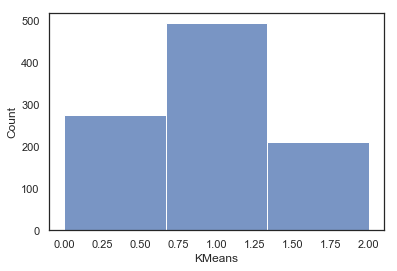

In [55]:
# How are the clusters distributed?
ax = sns.histplot(data=rs, x=c_nm, bins=k_pref);

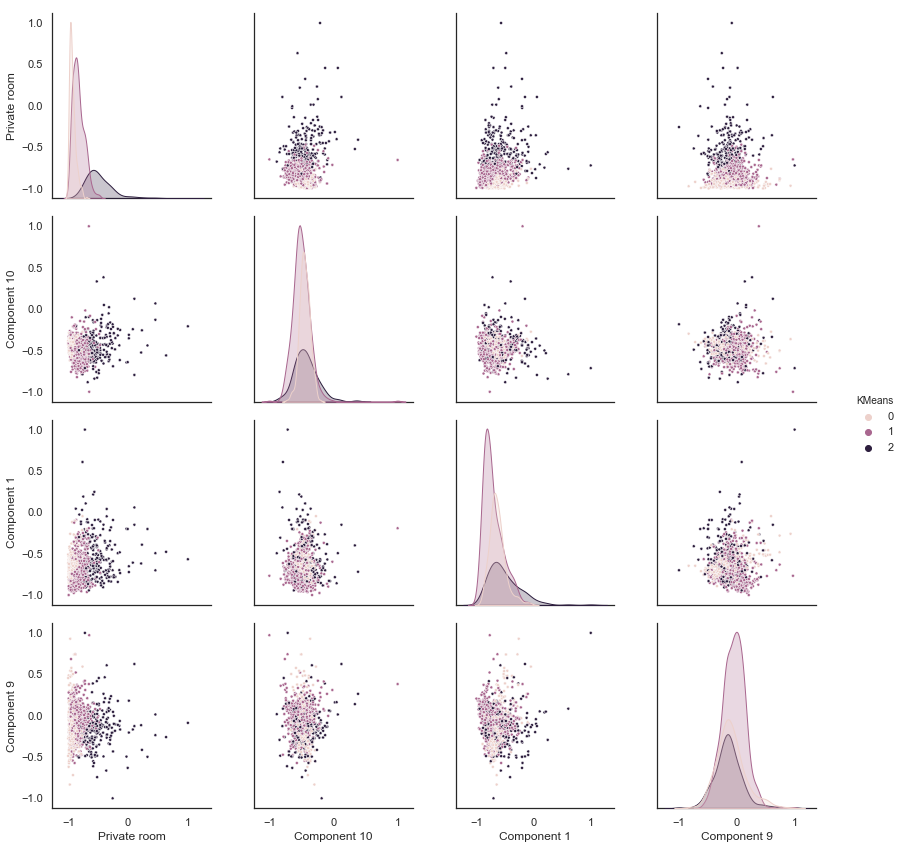

In [56]:
# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a few
sns.set(style="white")
sns.pairplot(rs, 
             vars=cols_to_plot, 
             hue=c_nm, markers=".", height=3, diag_kind='kde');

And here's a map!

AttributeError: 'DataFrame' object has no attribute 'dtype'

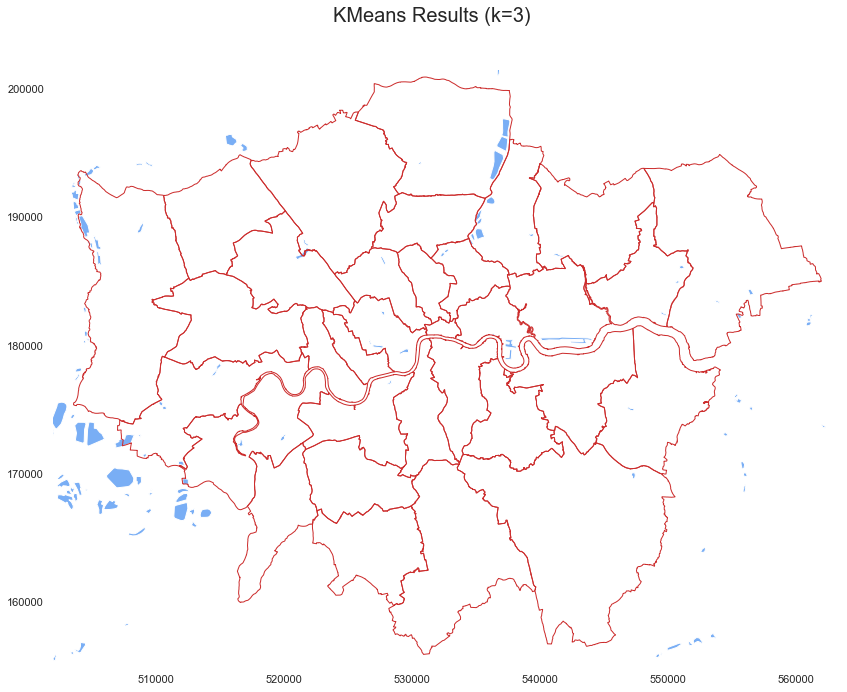

In [61]:
fig, ax = plt_ldn(water, boroughs)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=['Component 1', 'Component 2', 'Component 3'], ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

<div style="border: dotted 1px red; padding: 10px; margin: 5px; background-color: rgb(255,249,249);"><i>Stop</i>: What critical assumption did we make when running this analysis?</div>

## Second K-Means Clustering

#### The 'Right' Number of Clusters

There's more than one way to find the 'right' number of clusters. In Singleton's _Geocomputation_ chapter they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (2...n) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always some benefit to adding more clusters (the perfect clustering is k==n), so you don't always see a knee.

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM).

Either way, to evaluate this in a systematic way, we want to do multiple k-means clusterings for multiple values of k and then we can look at which gives the best results...

Let's try clustering across a wider range.

In [ ]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(??,??):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(??).fit(cldf)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(cldf, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

We can use the largest average silhouette score to determine the 'natural' number of clusters in the data, but that that's only if we don't have any kind of underlying theory, other empirical evidence, or even just a reason for choosing a different value... Again, we're now getting in areas where your judgement and your ability to communicate your rationale to readers is the key thing.

#### Final Clustering 

So although we should probably pick the largest silhouette scores, that's `k=2` which kind of defeats the purpose of clustering in the first place. In the absence of a _compelling_ reason to pick 2 or 3 clusters, let's have a closer look at the _next_ maximum silhouetted score:

In [ ]:
k_pref=??
    
#############
# Do the clustering using the main columns
kmeans = KMeans(??).fit(cldf)

# Convert to a series
s = pd.Series(kmeans.labels_, index=cldf.index, name=c_nm)
rs[c_nm] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(cldf, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(cldf, kmeans.labels_)
    
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, cldf.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(cldf[cldf.columns[0]], cldf[cldf.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

<div style="border: dotted 1px red; padding: 10px; margin: 5px; background-color: rgb(255,249,249);"><i>Stop</i>: Make sure that you understand how the silhouette plot and value work, and why your results may diverge from mine..</div> 

In [ ]:
fig, ax = plt_ldn(water, boroughs)
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

#### 'Representative' Centroids

To get a sense of how these clusters differ we can try to extract 'representative' centroids (mid-points of the multi-dimensional cloud that constitutes a cluster). In the case of k-means this will work quite will since the clusters are explicitly built around mean centroids. There's also a k-medoids clustering approach built around the median centroid.

In [ ]:
centroids = None
for k in sorted(rs[c_nm].unique()):
    print(f"Processing cluster {k}")

    c = rs[rs[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=c.columns.values)
    centroids = centroids.append(c.mean(), ignore_index=True)
    
odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

odf = odf[~odf.Variable.isin(['Borough','msoa11hclnm','Subregion','geometry'])]
g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

## DBSCAN

For what it's worth, I've had _enormous_ trouble with DBSCAN and this kind of data. I don't think it deals very well with more than three dimensions, so the flexbility to not have to specify the number of clusters is balanced with a density-based approach that is severely hampered by high-dimensional distance-inflation.

In [ ]:
cldf2 = cldf.loc[:,['Component 1','Component 2']]
cldf2.head()

#### Work out the Neighbour Distance

We normally look for some kind of 'knee' to set the distance.

In [ ]:
nbrs = NearestNeighbors(n_neighbors=2).fit(cldf2)
distances, indices = nbrs.kneighbors(cldf2)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.gcf().suptitle("Nearest Neighbour Distances");

#### Exploration

There are two values that need to be specified: `eps` and `min_samples`. Both seem to be set largely by trial and error. It's easiest to set `min_samples` first since that sets a floor for your cluster size and then `eps` is basically a distance metric that governs how far away something can be from a cluster and still be considered part of that cluster.

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. This next step may take quite a lot of time since we are iterating through many, many values of Epsilon to explore how the clustering result changes and how well this matches up with (or doesn't) the graph above.</div>

In [ ]:
c_nm = 'DBSCAN'

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.4f}'.format(x))

el  = []

max_clusters  = 10
cluster_count = 1

iters = 0

for e in np.arange(0.025, 0.25, 0.005):
    
    if iters % 25==0: print(f"{iters} epsilons explored.") 
    
    # Run the clustering
    dbs = DBSCAN(eps=e, min_samples=cldf2.shape[1]+1).fit(cldf2)
    
    # See how we did
    s = pd.Series(dbs.labels_, index=cldf2.index, name=c_nm)
    
    row = [e]
    data = s.value_counts()
    
    for c in range(-1, max_clusters+1):
        try:
            if np.isnan(data[c]):
                row.append(None)
            else: 
                row.append(data[c])
        except KeyError:
            row.append(None)
    
    el.append(row)
    iters+=1

edf = pd.DataFrame(el, columns=['Epsilon']+["Cluster " + str(x) for x in list(range(-1,max_clusters+1))])

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("Done.")

In [ ]:
odf = pd.DataFrame(columns=['Epsilon','Cluster','Count'])

for i in range(0,len(edf.index)):
    row = edf.iloc[i,:]
    for c in range(1,len(edf.columns.values)):
        if row[c] != None and not np.isnan(row[c]):
            d = {'Epsilon':row[0], 'Cluster':f"Cluster {c-2}", 'Count':row[c]}
            odf = odf.append(d, ignore_index=True)

odf['Count'] = odf.Count.astype(float)

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=odf, x='Epsilon', y='Count', hue='Cluster');
ax.vlines(0.06, 0, ax.get_ylim()[1], linestyle='dashed', color='r')

In [ ]:
e = 0.06
dbs = DBSCAN(eps=e, min_samples=cldf2.shape[1]+1).fit(cldf2.values)
s = pd.Series(dbs.labels_, index=cldf2.index, name=c_nm)
rs[c_nm] = s
print(s.value_counts())

#### Mapping Clustering Results

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. My sense is that these results are a bit rubbish: the majority of items are assigned to <i>one cluster</i>??? I've tried PCA on the standardised data and that made little difference. This should also have worked <i>better</i> but it seems that a small number of LSOAs are so utterly different that the more sophisticated clustering algorithm effectively 'chokes' on them.</div>

In [ ]:
fig, ax = plt_ldn(water, boroughs)
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, legend=True, categorical=True);

In [ ]:
centroids = None
for k in sorted(rs[c_nm].unique()):
    print(f"Processing cluster {k}")

    clsoas = rs[rs[c_nm]==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=clsoas.columns.values)
    centroids = centroids.append(clsoas.mean(), ignore_index=True)

odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index(c_nm)
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)

# Drop outliers
odf = odf[odf.Cluster >= 0]
odf.drop(index=odf[odf.Variable.isin(['geometry','KMeans'])].index, inplace=True)

g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")

del(odf, centroids)

#### Bonus!

See if you can work out why we have this issue by plotting the first 2 components... We _could_ actually try clusteirng on secondary components instead (e.g. 2 and 3, or 3 and 4) on the basis that the first one is so dominant.

## OPTICS

This one invites you to experiment wih different values of $\epsilon$ so it makes even fewer assumptions than DBSCAN but is even more computationally intensive. I've deliberately left this untested so I can't be sure it will work and you'll need to debug...

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. This next step may take quite a lot of time since the algorithm is making far fewer assumptions about the structure of the data. On a 2018 MacBook Pro with 16GB of RAM it took about 5 minutes.</div>

In [ ]:
c_nm = 'Optics'

# Can try to set this from DBSCAN results
e = 0.06

import math

# Run the clustering
opt = OPTICS(min_samples=len(cldf2.columns)+1, max_eps=math.ceil(e * 100)/10, n_jobs=-1).fit(cldf2)

# See how we did
s = pd.Series(opt.labels_, index=cldf.index, name=c_nm)
rs[c_nm] = s

# Distribution
print(s.value_counts())

## Self-Organising Maps

SOMs offer a _fourth_ type of clustering algorithm. They are a relatively 'simple' type of neural network in which the 'map' (of the SOM) adjusts to the data: we're going to see how this works over the next few code blocks, but the main thing is that, unlike the above approaches, SOMs build a 2D map of a higher-dimensional space and use this as a mechanism for subsequently clustering the raw data. In this sense there is a conceptual link between SOMs and PCA or tSNE (another form of dimensionality reduction).

#### Training the SOM

We are going to actually train the SOM using the input data. This is where you specify the input parameters that have the main effect on the clustering results.

In [ ]:
from sompy.sompy import SOMFactory

In [ ]:
c_nm = 'SOM'

sm = SOMFactory().build(
    cldf.values, mapsize=(10,15),
    normalization='var', initialization='random', component_names=cldf.columns.values)
sm.train(n_job=4, verbose=False, train_rough_len=2, train_finetune_len=5)

How good is the fit?

In [ ]:
topographic_error  = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = {0:0.5f}; Quantization error = {1:0.5f}".format(topographic_error, quantization_error))

How do the results look?

In [ ]:
from sompy.visualization.mapview import View2D
view2D = View2D(10, 10, "rand data", text_size=10)
view2D.show(sm, col_sz=4, which_dim="all", denormalize=True)
plt.savefig(f"{c_nm}-Map.png", dpi=200)

#### Here's What I Got

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: Your results may differ.</div>

<img src="https://github.com/jreades/i2p/blob/master/practicals/img/SOM-Map.png?raw=true" alt="SOM Clustering Results" width="800" />

How many data points were assigned to each BMU?

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView
vhts = BmuHitsView(15, 15, "Hits Map", text_size=8)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=9, cmap="plasma", logaritmic=False)
plt.savefig(f"{c_nm}-BMU Hit View.png", dpi=200)

How many clusters do we want and where are they on the map?

In [ ]:
from sompy.visualization.hitmap import HitMapView

k_val = 6 # The way this library is set up it's hard to explore the k-means clustering of Hits
sm.cluster(k_val)
hits  = HitMapView(15, 15, "Clustering", text_size=14)
a     = hits.show(sm)
plt.savefig(f"{c_nm}-Hit Map View.png", dpi=200)

Finally, let's get the cluster results and map them back on to the data points:

In [ ]:
# Get the labels for each BMU
# in the SOM (15 * 10 neurons)
clabs = sm.cluster_labels

# Project the data on to the SOM
# so that we get the BMU for each
# of the original data points 
# (This is similar to the transform 
# function is sklearn)
bmus  = sm.project_data(cldf.values)

# Turn the BMUs into cluster labels
# and append to the data frame
s = pd.Series(clabs[bmus], index=cldf.index, name=c_nm)

rs[c_nm] = s

In [ ]:
fig, ax = plt_ldn(water, boroughs)
fig.suptitle(f"{c_nm} Results", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, legend=True, categorical=True);

#### Result!

<div style="padding:5px;margin-top:5px;margin-bottom:5px;border:dotted 1px red;background-color:rgb(255,233,233);color:red">WARNING. These are the results from the approach that is closest to the one outlined in <i>Geocomputation</i>.</div>

<img src="https://github.com/jreades/i2p/blob/master/practicals/img/SOM-Cluster-Map.png?raw=true" alt="SOM Clustering Results Mapped" width="800" />

## Wrap-Up

- Find the appropriate eps value: [Nearest Neighbour Distance Functions](https://nbviewer.jupyter.org/github/pysal/pointpats/blob/master/notebooks/distance_statistics.ipynb#Nearest-Neighbor-Distance-Functions) or [Interevent Distance Functions](https://nbviewer.jupyter.org/github/pysal/pointpats/blob/master/notebooks/distance_statistics.ipynb#Interevent-Distance-Functions)
- [Clustering Points](https://darribas.org/gds_course/content/bH/lab_H.html#clusters-of-points)
- [Regionalisation algorithms with Aglomerative Clustering](https://darribas.org/gds_course/content/bG/lab_G.html#regionalization-algorithms)


You've reached the end, you're done... 

Er, no. This is barely scratching the surface! I'd suggest that you go back through the above code and do three things:
1. Add a lot more comments to the code to ensure that really have understood what is going on.
2. Try playing with some of the parameters (e.g. my thresholds for skew, or non-normality) and seeing how your results change.
3. Try outputting additional plots that will help you to understand the _quality_ of your clustering results (e.g. what _is_ the makeup of cluster 1? Or 6? What has it picked up? What names would I give these clsuters?).

If all of that seems like a lot of work then why not learn a bit more about machine learning before calling it a day?

See: [Introduction to Machine Learning with Scikit-Learn](http://www.slideshare.net/BenjaminBengfort/introduction-to-machine-learning-with-scikitlearn).